In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cornell-moviedialog-corpus/movie_conversations.txt
/kaggle/input/cornell-moviedialog-corpus/README.txt
/kaggle/input/cornell-moviedialog-corpus/.DS_Store
/kaggle/input/cornell-moviedialog-corpus/chameleons.pdf
/kaggle/input/cornell-moviedialog-corpus/movie_titles_metadata.txt
/kaggle/input/cornell-moviedialog-corpus/raw_script_urls.txt
/kaggle/input/cornell-moviedialog-corpus/movie_characters_metadata.txt
/kaggle/input/cornell-moviedialog-corpus/movie_lines.txt
/kaggle/input/images/mat.JPG


In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import unicodedata
import codecs
import itertools

checking for GPU and setting it to gpu if cuda is available else cpu

In [3]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda"if CUDA else "cpu")

# Part 1: Data Preprocessing

In [4]:
lines_filepath = '/kaggle/input/cornell-moviedialog-corpus/movie_lines.txt'
conv_filepath = '/kaggle/input/cornell-moviedialog-corpus/movie_conversations.txt'

In [5]:
#
with open(lines_filepath,'r',encoding='iso-8859-1') as file:
    lines = file.readlines()
for line in lines[:5]:
    print(line.strip())

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.


from the movie lines, 'BIANCA' and 'CAMERON' is the character name and the last part is what these character says.

u0 is the character id and m0 is the movie id

In [6]:
line_fields = ["lineID", "characterID", "movieID", "character", "text"]
lines={}

with open(lines_filepath,'r',encoding='iso-8859-1') as file:
    for line in file:
        values = line.split(" +++$+++ ")
        lineObj={}
        #extract the fields
        for i, field in enumerate(line_fields):
            lineObj[field]= values[i]
        lines[lineObj['lineID']] = lineObj

In [7]:
conv_fields = ["character1ID", " character2ID", "movieID", "utterancesIDs"]
conversations=[]
with open (conv_filepath,'r', encoding='iso-8859-1') as file:
    for line in file:
        values = line.split(" +++$+++ ")
        convObj={}
        for i,field in enumerate(conv_fields):
            convObj[field] = values[i]
            
        lineIds = eval(convObj["utterancesIDs"])
        convObj["lines"] = []
        for lineId in lineIds:
            convObj["lines"].append(lines[lineId])
        conversations.append(convObj)

In [8]:
conversations[0]['lines'][0]['text'].strip()

'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.'

In [9]:
conversations[0]['lines'][1]['text']

"Well, I thought we'd start with pronunciation, if that's okay with you.\n"

In [10]:
#Extract sentences from the conversations
qa_pairs = []
for conversation in conversations:
    for i in range(len(conversation['lines'])-1):
        input_line= conversation['lines'][i]['text'].strip()
        target_line=conversation['lines'][i+1]['text'].strip()
        
        if input_line and target_line:
            qa_pairs.append([input_line,target_line])
            

In [11]:
len(qa_pairs)

221282

In [12]:
qa_pairs[:5]

[['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
  "Well, I thought we'd start with pronunciation, if that's okay with you."],
 ["Well, I thought we'd start with pronunciation, if that's okay with you.",
  'Not the hacking and gagging and spitting part.  Please.'],
 ['Not the hacking and gagging and spitting part.  Please.',
  "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"],
 ["You're asking me out.  That's so cute. What's your name again?",
  'Forget it.'],
 ["No, no, it's my fault -- we didn't have a proper introduction ---",
  'Cameron.']]

In [13]:
#wrting the QnA data to a new file
dataFile = "formatted_movie_lines.txt"

delimiter ='\t'
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

with open(dataFile, 'w', encoding='iso-8859-1') as file:
    writer = csv.writer(file,delimiter=delimiter)
    for pair in qa_pairs:
        writer.writerow(pair)
print("Done writing to the file")

Done writing to the file


In [14]:
#visualize the data
dataFile="./formatted_movie_lines.txt"
with open(dataFile, 'rb') as file:
    lines = file.readlines()
    for line in lines[:5]:
        print(line)

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"


In [15]:
PAD_Token = 0 #to pad short sentences
SOS_Token = 1 #start of sentence
EOS_Token = 2 #end of sentence

class Vocabulary:
    def __init__(self,name):
        self.name=name
        self.word2index={} #mapping a number to each word
        self.word2count={} #frequency of words
        self.index2word={PAD_Token:"PAD", SOS_Token:"SOS", EOS_Token:"EOS"}
        self.num_words=3 #PAD,SOS,EOS
        
    def addSentence(self,sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.word2count[word]=1
            self.index2word[self.num_words]=word
            self.num_words+=1
        else:
            self.word2count[word]+=1
            
    def trim(self, min_count):
        keep_words=[]
        for word,count in self.word2count.items():
            if count>=min_count:
                keep_words.append(word)
        
        print(len(keep_words))
        print(len(self.word2index))
        print(f'keep words {len(keep_words)}/{len(self.word2index)} = {len(keep_words)/len(self.word2index)}')
        
        #re-initialize dictionaries
        
        self.word2index={} 
        self.word2count={} 
        self.index2word={PAD_Token:"PAD", SOS_Token:"SOS", EOS_Token:"EOS"}
        self.num_words=3 
        
        for word in keep_words:
            self.addWord(word)

In [16]:
# unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!="Mn")

This removes the accent and returns the simple form of it. 
Below is one of the examples which turns a unicode string to plain ascii

In [17]:
unicodeToAscii("Comment ça va")

'Comment ca va'

In [18]:
def normalizeString(s):
    s=unicodeToAscii(s.lower().strip())
    #replace any .!? with white space and the character i.e "!" = " !"
    s=re.sub(r"([.!?])", r" \1", s)
    #Remove any character that is not a sequence of lower case or upper case characters
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    #remove a sequence of whitespace characters
    s=re.sub(r"\s+", r" ", s).strip()
    return s
    

from the sentence below we are removing non alpha characters and also replacing "!" with " !"

In [19]:
normalizeString("hello123abc! qq?")

'hello abc ! qq ?'

In [20]:
dataFile = "formatted_movie_lines.txt"
#Read the file and split into lines

lines = open(dataFile, encoding='iso-8859-1').read().strip().split("\n")
pairs=[[normalizeString(s) for s in pair.split('\t')]for pair in lines]

In [21]:
pairs[:5]

[['can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .',
  'well i thought we d start with pronunciation if that s okay with you .'],
 ['well i thought we d start with pronunciation if that s okay with you .',
  'not the hacking and gagging and spitting part . please .'],
 ['not the hacking and gagging and spitting part . please .',
  'okay . . . then how bout we try out some french cuisine . saturday ? night ?'],
 ['you re asking me out . that s so cute . what s your name again ?',
  'forget it .'],
 ['no no it s my fault we didn t have a proper introduction', 'cameron .']]

In [22]:
#creating vocabulary object
voc = Vocabulary("movie-dialog corpus")

In [23]:
#remove sentences which are more than the MAX_LENGTH
MAX_LENGTH=10
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    

In [24]:
pairs = [pair for pair in pairs if len(pair) > 1]
print(f"There are {len(pairs)} pairs/conversations in the dataset")
pairs=filterPairs(pairs)
print(f"There are {len(pairs)} pairs/conversations in the dataset after filtering")

There are 221282 pairs/conversations in the dataset
There are 64271 pairs/conversations in the dataset after filtering


In [25]:
#loop through each pair and add it to vocabulary

for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print(f"Counted words: {voc.num_words}")

Counted words: 18008


In [26]:
for pair in pairs[:5]:
    print(pair)

['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']


Now we are gonna trim the words that do not appear often as we dont want to confuse our model with words that are rare.

In [27]:
MIN_COUNT=3
def trimRareWords(voc,pairs, MIN_COUNT):
    
    keep_pairs=[]
    voc.trim(MIN_COUNT)
    for pair in pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        keep_input=True
        keep_output=True
        
        #check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input=False
                break
                
        #check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output=False
                break
        
        if keep_input and keep_output:
            keep_pairs.append(pair)
        
    print(f"Trimmed from {len(pairs)} pairs to {len(keep_pairs)}")
            
    return keep_pairs
    

In [28]:
pairs=trimRareWords(voc,pairs,MIN_COUNT)

7823
18005
keep words 7823/18005 = 0.43449041932796445
Trimmed from 64271 pairs to 53165


# Data Preprocessing

If we are interested in leveraging GPU parallelization capabilities, we need train the data in batches. To accomodate sentences of different sizes in the same batch, we need to make batched iput tensor of shape (max_length, batch size), where sentences shorter than max_length are padded with zero. Our english sentences will be converted to tensors with each word mapping to its index in the tensor with shape (batch size , max_length)and indexing first dimension would return a full sequence across all time steps. therefore we transpose our input tensor to (batch size , max_length).

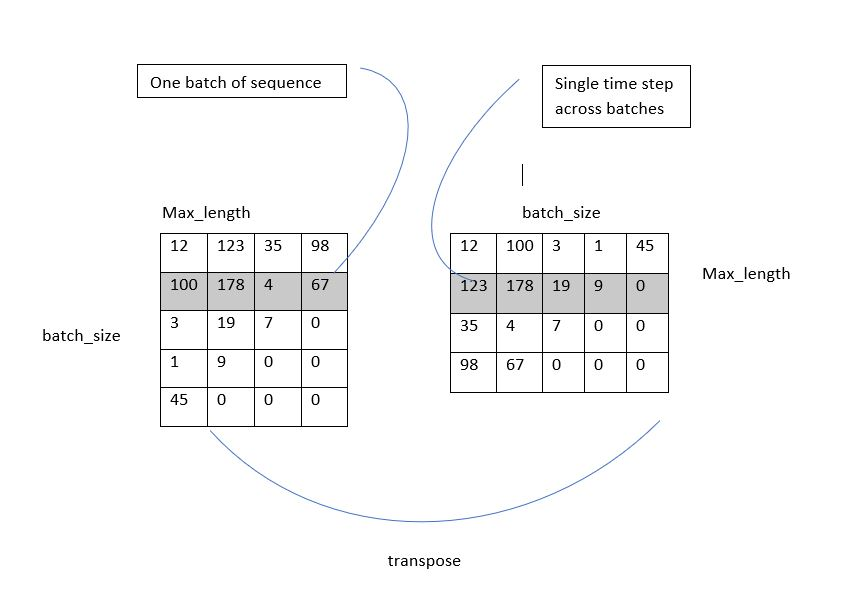

                    



In [29]:
def indexFromSentence(voc,sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_Token]

In [30]:
pairs[3][0]

'have fun tonight ?'

In [31]:
indexFromSentence(voc, pairs[3][0])

[8, 31, 22, 6, 2]

We have index for four words and the last index is for EOS token

In [32]:
pairs[:10]

[['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .'],
 ['then that s all you had to say .', 'but'],
 ['but', 'you always been this selfish ?'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['what good stuff ?', 'the real you .'],
 ['wow', 'let s go .']]

In [33]:
#testing a sample
inp=[]
out=[]

for pair in pairs[:5]:
    inp.append(pair[0])
    out.append(pair[1])
indexes= [indexFromSentence(voc,sentence) for sentence in inp]
indexes
    

[[3, 4, 2],
 [7, 8, 9, 10, 4, 11, 12, 13, 2],
 [16, 4, 2],
 [8, 31, 22, 6, 2],
 [33, 34, 4, 4, 4, 2]]

We want to pad zero for the list whose length is less than the max_length. We will use zip_longest method to pad the list.

In [34]:
list(itertools.zip_longest(*indexes, fillvalue=0))

[(3, 7, 16, 8, 33),
 (4, 8, 4, 31, 34),
 (2, 9, 2, 22, 4),
 (0, 10, 0, 6, 4),
 (0, 4, 0, 2, 4),
 (0, 11, 0, 0, 2),
 (0, 12, 0, 0, 0),
 (0, 13, 0, 0, 0),
 (0, 2, 0, 0, 0)]

In [48]:
def zeroPadding(tensor, fillvalue=0):
    return list(itertools.zip_longest(*tensor, fillvalue=0))

In [36]:
leng =[len(ind) for ind in indexes]
leng

[3, 9, 3, 5, 6]

In [49]:
test_result = zeroPadding(indexes)
print(f"maximum length={len(test_result)}")
test_result

maximum length=9


[(3, 7, 16, 8, 33),
 (4, 8, 4, 31, 34),
 (2, 9, 2, 22, 4),
 (0, 10, 0, 6, 4),
 (0, 4, 0, 2, 4),
 (0, 11, 0, 0, 2),
 (0, 12, 0, 0, 0),
 (0, 13, 0, 0, 0),
 (0, 2, 0, 0, 0)]

In [50]:
def binaryMatrix(tensor, value=0):
    m=[]
    for i, seq in enumerate(tensor):
        m.append([])
        for token in seq:
            if token==PAD_Token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m
    

In [51]:
binary_result= binaryMatrix(test_result)

In [52]:
binary_result

[[1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [0, 1, 0, 1, 1],
 [0, 1, 0, 1, 1],
 [0, 1, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0]]

In [53]:
#Returns padded input sequence tensor and tensor lengths for each sentence
def inputVar(tensor,voc):
    indexes_batch = [indexFromSentence(voc,sentence) for sentence in tensor]
    lengths=torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar=torch.LongTensor(padList)
    return padVar, lengths

In [54]:
#Returns padded target sequence tensor, padding mask and max target length
def outputVar(tensor,voc):
    indexes_batch = [indexFromSentence(voc,sentence) for sentence in tensor]
    max_target_len=max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask=binaryMatrix(padList)
    mask=torch.ByteTensor(mask)
    padVar=torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [55]:
#returns all items for a given batch of pairs
def batch2TrainData(voc,pairs_batch):
    #sort the questions in descending length
    pairs_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, target_batch = [],[]
    for pair in pairs_batch:
        input_batch.append(pair[0])
        target_batch.append(pair[1])
    print(input_batch)
    inp,lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(target_batch, voc)
    return inp,lengths,output, mask, max_target_len

In [44]:
[random.choice(pairs) for _ in range(5)]

[['my lady viola .', 'lord wessex . you have been waiting .'],
 ['luke . where you goin ?', 'on my own .'],
 ['you ll be alive .', 'with a man in my head . . .'],
 ['how do you do my dear .', 'oh brother .'],
 ['what s that ?', 'well you remember my kid sister mary ?']]

In [45]:
pairs[:5]

[['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .']]

In [56]:
#sample validation
batch_size_tmp = 5
#batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size_tmp)])
batches = batch2TrainData(voc, pairs[:5])
input_var, lengths, target_var, mask, max_target_len = batches

print(f"input variable:")
print(input_var)
print(f"input lengths:")
print(lengths)
print(f"target variable:")
print(target_var)
print(f"output variable lengths:")
print(max_target_len)
print(f"mask:")
print(mask)

['you have my word . as a gentleman', 'well no . . .', 'have fun tonight ?', 'there .', 'hi .']
[[7, 8, 9, 10, 4, 11, 12, 13, 2], [33, 34, 4, 4, 4, 2], [8, 31, 22, 6, 2], [3, 4, 2], [16, 4, 2]]
tensor([9, 6, 5, 3, 3])
[(7, 33, 8, 3, 16), (8, 34, 31, 4, 4), (9, 4, 22, 2, 2), (10, 4, 6, 0, 0), (4, 4, 2, 0, 0), (11, 2, 0, 0, 0), (12, 0, 0, 0, 0), (13, 0, 0, 0, 0), (2, 0, 0, 0, 0)]
tensor([[ 7, 33,  8,  3, 16],
        [ 8, 34, 31,  4,  4],
        [ 9,  4, 22,  2,  2],
        [10,  4,  6,  0,  0],
        [ 4,  4,  2,  0,  0],
        [11,  2,  0,  0,  0],
        [12,  0,  0,  0,  0],
        [13,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0]])
